In [1]:
# turn off pretty printing, because the slides can't handle the verticality
%pprint

Pretty printing has been turned OFF


In [2]:
# load supriya's ipython extension to capture audio/graphs
%load_ext supriya.ext.ipython

In [3]:
# kill any running scsynth/supernova servers
from supriya.scsynth import kill

kill()

In [4]:
# turn soundcheck on
import supriya

server = supriya.Server().boot()
with server.at():
    with server.add_synthdefs(supriya.default):
        server.add_synth(supriya.default)

In [5]:
# turn soundcheck off
_ = server.quit()

March 14th, 2025

# Supriya: a Python API for SuperCollider

**Joséphine Wolf Oberholtzer (she/her)** <br/>
https://josephine-wolf-oberholtzer.com/

https://github.com/supriya-project/supriya/ <br/>
tree/main/docs/notebooks/supercollider-symposium-2025/presentation.ipynb

<div style="display: flex; flex-direction: row; justify-content: space-around;">
  <div style="text-align: center;">
    <img src="qr-bio.png" height="250" width="250"/><br />
    BIO
  </div>
  <div><img src="apsara.jpg" width="250"/></div>
  <div style="text-align: center;">
    <img src="qr-github.png" height="250" width="250"/><br />
    GITHUB
  </div>
</div>

## Preamble

### Who am I

- ~16 years of experience in Python
- PhD from Harvard in music composition
    - massively multichannel tape music
    - symbolic composition in Python & LilyPond via Abjad
- In industry for over a decade: Forced Exposure, Discogs, Capital One, Cortico/MIT
- Staff engineer at Cortico: systems architecture, backend, devops

### What Supriya is for

- A foundational layer for application code
- Consistent API for realtime and non-realtime
- Consistent API for threaded and async concurrency models
- Musical-time-aware clocks
- Especially suited for headless applications
- Let's just make it easy to use SuperCollider inside the Python ecosystem!

### What Supriya isn't for

- Recreating sclang's class library
- Live coding (but you can try... we're gonna do it in a moment)
- UIs (other libraries exist)
- IDEs (other libraries exist)
- MIDI (other libraries exist)
- etc.

### Why Python?

- Many orders of magnitude more people use Python than sclang
- Visibility / support is very good
- Huge vibrant ecosystem (most things I might want somebody already invented)
  - strong support for web frameworks, systems programming, data science / ml / scientific computing, etc.
- Relatively simple syntax, _initially_ at least
- Good developer experience (tracebacks, debugging, testing, linting, formatting, type checking, CI, docs tooling, etc.)

### What I'm _not_ gonna cover

- How to use Python (although you'll probably learn a little)
- How to use SuperCollider
- How to install Supriya
   - We don't have time!
   - Ask me after!
   - https://supriya-project.github.io/supriya/installation.html
   - `pip install supriya`
- Making really beautiful noises: this is orthogonal

### OK, but what _am_ I gonna cover

- Basic usage
- Design principles
- Server, scores, context entities, synthdefs, osc, clocks, patterns, asyncio, testing, etc.
  - Probably not getting to all of these, but we'll try 

### Design principles?

- **Make it explicit**: avoid globals, avoid implicitness
- **Make it ~boring~ simple**: avoid multiple means to the same ends, resist flexibility, "there should be one (and preferably only one) obvious way to do it"
- **Make it verbose**: give everything (non-fanciful) names, avoid abbreviations, prefer keywords over positionals, strive for using terms of art aligned with the wider language ecosystem
- **Make it self-similar**: strive for identical means of interacting with similar things
- **Make it narrowly focused**: don't have to _implement_ what's already implemented in the rest of the ecosystem, but may have to _integrate_ with it
- **Make it easily introspectable, easily testable**

## Realtime contexts: Servers

### Import supriya

In [6]:
# supriya is a package, so let's import it
import supriya

In [7]:
# everything in python is an object, so we can do some inspecting
supriya

<module 'supriya' from '/Users/josephine/Source/github.com/supriya-project/supriya/supriya/__init__.py'>

In [8]:
# let's look at the names defined inside the supriya namespace
dir(supriya)

['AddAction', 'AsyncClock', 'AsyncOfflineClock', 'AsyncServer', 'BaseClock', 'BaseServer', 'Buffer', 'BufferGroup', 'Bus', 'BusGroup', 'CalculationRate', 'Clock', 'ClockContext', 'Context', 'DoneAction', 'Envelope', 'Group', 'HeaderFormat', 'Node', 'OfflineClock', 'Options', 'OscBundle', 'OscCallback', 'OscMessage', 'ParameterRate', 'Pattern', 'SampleFormat', 'Score', 'Server', 'ServerLifecycleEvent', 'ServerShutdownEvent', 'Synth', 'SynthDef', 'SynthDefBuilder', 'TimeUnit', 'UGen', 'UGenOperable', 'UGenVector', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '__version_info__', '_version', 'assets', 'assets_path', 'clocks', 'contexts', 'conversions', 'default', 'enums', 'exceptions', 'ext', 'find_free_port', 'graph', 'io', 'osc', 'output_path', 'patterns', 'play', 'plot', 'render', 'sclang', 'scsynth', 'synthdef', 'typing', 'ugens', 'utils']

### Import `Server`

In [9]:
# we can import individual names out of supriya's namespace
from supriya import Server

In [10]:
# instantiate the server
server = Server()

In [11]:
# let's look at the names inside the Server namespace
dir(server)

['__abstractmethods__', '__annotations__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_node_to_children', '_add_request_with_completion', '_add_requests', '_allocate_id', '_apply_completions', '_audio_bus_allocator', '_boot_future', '_boot_status', '_buffer_allocator', '_buffers', '_client_id', '_contexts', '_control_bus_allocator', '_exit_future', '_free_id', '_get_allocator', '_get_moment', '_get_next_sync_id', '_get_options', '_get_request_context', '_handle_done_b_alloc', '_handle_done_b_alloc_read', '_handle_done_b_alloc_read_channel', '_handle_done_b_free', '_handle_fail', '_h

In [12]:
# actually let's look at the public name inside the Server namespace...
# this is a list comprehension with a filtering clause:
[name for name in dir(server) if not name.startswith("_")]

['add_buffer', 'add_buffer_group', 'add_bus', 'add_bus_group', 'add_group', 'add_synth', 'add_synthdefs', 'at', 'audio_input_bus_group', 'audio_output_bus_group', 'boot', 'boot_future', 'boot_status', 'clear_schedule', 'client_id', 'close_buffer', 'connect', 'copy_buffer', 'default_group', 'disconnect', 'do_nothing', 'dump_tree', 'exit_future', 'fill_buffer', 'fill_bus_range', 'free_all_synthdefs', 'free_buffer', 'free_buffer_group', 'free_bus', 'free_bus_group', 'free_group_children', 'free_node', 'free_synthdefs', 'generate_buffer', 'get_buffer', 'get_buffer_range', 'get_bus', 'get_bus_range', 'get_synth_control_range', 'get_synth_controls', 'is_owner', 'latency', 'load_synthdefs', 'load_synthdefs_directory', 'map_node', 'move_node', 'name', 'normalize_buffer', 'options', 'order_nodes', 'osc_protocol', 'pause_node', 'process_protocol', 'query_buffer', 'query_node', 'query_status', 'query_tree', 'query_version', 'quit', 'read_buffer', 'reboot', 'register_lifecycle_callback', 'register

### Server options

In [13]:
# print the server's "interpreter representation"
server

<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

In [14]:
# inspect the server's options
server.options

Options(audio_bus_channel_count=1024, block_size=64, buffer_count=1024, control_bus_channel_count=16384, executable=None, hardware_buffer_size=None, initial_node_id=1000, input_bus_channel_count=8, input_device=None, input_stream_mask='', ip_address='127.0.0.1', load_synthdefs=True, maximum_logins=1, maximum_node_count=1024, maximum_synthdef_count=1024, memory_locking=False, memory_size=8192, output_bus_channel_count=8, output_device=None, output_stream_mask='', password=None, port=57110, protocol='udp', random_number_generator_count=64, realtime=True, restricted_path=None, safety_clip=None, sample_rate=None, threads=6, ugen_plugins_path=None, verbosity=0, wire_buffer_count=64, zero_configuration=False)

In [15]:
# options correspond to CLI flags
!scsynth -h

supercollider_synth  options:
   -v print the supercollider version and exit
   -u <udp-port-number>    a port number 0-65535
   -t <tcp-port-number>    a port number 0-65535
   -B <bind-to-address>
          Bind the UDP or TCP socket to this address.
          Default 127.0.0.1. Set to 0.0.0.0 to listen on all interfaces.
   -c <number-of-control-bus-channels> (default 16384)
   -a <number-of-audio-bus-channels>   (default 1024)
   -i <number-of-input-bus-channels>   (default 8)
   -o <number-of-output-bus-channels>  (default 8)
   -z <block-size>                     (default 64)
   -Z <hardware-buffer-size>           (default 0)
   -S <hardware-sample-rate>           (default 0)
   -b <number-of-sample-buffers>       (default 1024)
   -n <max-number-of-nodes>            (default 1024)
   -d <max-number-of-synth-defs>       (default 1024)
   -m <real-time-memory-size>          (default 8192)
   -w <number-of-wire-buffers>         (default 64)
   -r <number-of-random-seeds>         (d

### Boot the server

In [16]:
# boot her, returning the server (making this chainable)
server.boot()

<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

### Query the server

In [17]:
# ask for the query's status
# as reported via /status & /status.reply
server.status

StatusInfo(actual_sample_rate=44100.00000244759, average_cpu_usage=0.054519057273864746, group_count=2, peak_cpu_usage=0.4264693856239319, synth_count=0, synthdef_count=0, target_sample_rate=44100.0, ugen_count=0)

In [18]:
# print the node tree, assigning to a variable along the way
print(tree := server.query_tree())

NODE TREE 0 group
    1 group


In [19]:
# this is actually a query tree object, not just a string
# ... which is helpful in more complex unit testing situations
# ... because the tree can be annotated with information beyond what scsynth provides
# ... but we can still use string comparisons
tree

QueryTreeGroup(node_id=0, annotation=None, children=[QueryTreeGroup(node_id=1, annotation=None, children=[])])

### Quit the server

In [20]:
# quit the server
# note the status in the repr
server.quit()

<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

### Boot with options

In [21]:
# recall all the options from before
server.options

Options(audio_bus_channel_count=1024, block_size=64, buffer_count=1024, control_bus_channel_count=16384, executable=None, hardware_buffer_size=None, initial_node_id=1000, input_bus_channel_count=8, input_device=None, input_stream_mask='', ip_address='127.0.0.1', load_synthdefs=True, maximum_logins=1, maximum_node_count=1024, maximum_synthdef_count=1024, memory_locking=False, memory_size=8192, output_bus_channel_count=8, output_device=None, output_stream_mask='', password=None, port=57110, protocol='udp', random_number_generator_count=64, realtime=True, restricted_path=None, safety_clip=None, sample_rate=None, threads=6, ugen_plugins_path=None, verbosity=0, wire_buffer_count=64, zero_configuration=False)

In [22]:
# we can use those keywords to configure new options when booting, rebooting, quitting, etc.
server.boot(maximum_logins=2)

<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 2 -u 57110]>

ServerLifecycleEvent.QUITTING
ServerLifecycleEvent.DISCONNECTING
ServerLifecycleEvent.OSC_DISCONNECTED
ServerLifecycleEvent.DISCONNECTED
ServerLifecycleEvent.PROCESS_QUIT
ServerLifecycleEvent.QUIT
ServerLifecycleEvent.BOOTING
ServerLifecycleEvent.PROCESS_BOOTED
ServerLifecycleEvent.CONNECTING
ServerLifecycleEvent.OSC_CONNECTED
ServerLifecycleEvent.CONNECTED
ServerLifecycleEvent.BOOTED


### Multiple users

In [23]:
# We can create a handle to a second server proxy,
# pointed back at the same IP address and port as the first
other_server = Server()
other_server

<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

In [24]:
# note the port is basically the same as `other_server`
# not counting the -l flag which the connecting server ignores
server

<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 2 -u 57110]>

In [25]:
# connect to the original server via .connect()
other_server.connect()

<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

In [26]:
# note that the client IDs are different, as expected
print(f"{server.client_id=}")
print(f"{other_server.client_id=}")

server.client_id=0
other_server.client_id=1


In [27]:
# disconnect from the original server
other_server.disconnect()

<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

In [28]:
# the original server remains online
server

<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 2 -u 57110]>

### Lifecycle events

In [29]:
# servers emit a variety of "lifecycle events"
# while booting, connecting, disconnecting, quitting and crashing
for event_type in supriya.ServerLifecycleEvent:
    print(repr(event_type))

ServerLifecycleEvent.BOOTING
ServerLifecycleEvent.PROCESS_BOOTED
ServerLifecycleEvent.CONNECTING
ServerLifecycleEvent.OSC_CONNECTED
ServerLifecycleEvent.CONNECTED
ServerLifecycleEvent.BOOTED
ServerLifecycleEvent.OSC_PANICKED
ServerLifecycleEvent.PROCESS_PANICKED
ServerLifecycleEvent.QUITTING
ServerLifecycleEvent.DISCONNECTING
ServerLifecycleEvent.OSC_DISCONNECTED
ServerLifecycleEvent.DISCONNECTED
ServerLifecycleEvent.PROCESS_QUIT
ServerLifecycleEvent.QUIT


In [30]:
# define a simple callback to print the event
def on_event(event):
    print(repr(event))

In [31]:
# register the callback for every event type
# this is akin to sclang's doWhenBooted
for event_type in supriya.ServerLifecycleEvent:
    server.register_lifecycle_callback(event_type, on_event)
    other_server.register_lifecycle_callback(event_type, on_event)

In [32]:
# this will go through quitting then booting
server.reboot()

<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 2 -u 57110]>

In [33]:
# this will panic!
other_server.boot()

ServerLifecycleEvent.BOOTING
ServerLifecycleEvent.PROCESS_PANICKED


ServerCannotBoot: *** ERROR: failed to open UDP socket: address in use.

In [34]:
# and now just the quitting events
server.quit()

ServerLifecycleEvent.QUITTING
ServerLifecycleEvent.DISCONNECTING
ServerLifecycleEvent.OSC_DISCONNECTED
ServerLifecycleEvent.DISCONNECTED
ServerLifecycleEvent.PROCESS_QUIT
ServerLifecycleEvent.QUIT


<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 2 -u 57110]>

## Context Entities

... entities that live inside a synthesis _context_...

... Groups, Synths, Busses and Buffers ...

### Groups

In [35]:
server = Server().boot()

/Users/josephine/Source/github.com/supriya-project/supriya/supriya/contexts/realtime.py:236: FailWarning: /s_new SynthDef not found
  warnings.warn(" ".join(str(x) for x in message.contents), FailWarning)
/Users/josephine/Source/github.com/supriya-project/supriya/supriya/contexts/realtime.py:236: FailWarning: /n_free Node 1008 not found
  warnings.warn(" ".join(str(x) for x in message.contents), FailWarning)


In [36]:
# add a group
(group := server.add_group())

Group(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=1000, parallel=False)

In [37]:
print(dir(group))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__float__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__int__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__replace__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_valid_add_actions', 'active', 'add_group', 'add_synth', 'allocated', 'children', 'context', 'dump_tree', 'free', 'free_children', 'id_', 'map', 'move', 'order', 'parallel', 'parent', 'parentage', 'pause', 'query', 'query_tree', 'set', 'set_range', 'unpause']


In [38]:
# verify the group's in the node tree
print(server.query_tree())

NODE TREE 0 group
    1 group
        1000 group


In [39]:
# add a group to the group
child_group = group.add_group()
print(server.query_tree())

NODE TREE 0 group
    1 group
        1000 group
            1001 group


In [40]:
# move the child group into the default group
child_group.move(target_node=server.default_group, add_action="ADD_TO_TAIL")
print(server.query_tree())

NODE TREE 0 group
    1 group
        1000 group
        1001 group


In [41]:
# free the original parent group
group.free()
print(server.query_tree())

NODE TREE 0 group
    1 group
        1001 group


### Synths

In [42]:
# add a synth (this will fail with a warning)
synth = child_group.add_synth(synthdef=supriya.default)

In [43]:
# yet, we have a proxy to a synth (useless now, i know)
synth

Synth(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=1002, synthdef=<SynthDef: default>)

In [44]:
# but nothing on the server, because the request failed
print(server.query_tree())

NODE TREE 0 group
    1 group
        1001 group


#### Completions

In [45]:
# let's allocate the synthdef and the synth properly
# we use a "moment" to populate a _potential_ bundle
# and a "completion" to populate /d_recv's completion message
with server.at() as moment:
    with server.add_synthdefs(supriya.default) as completion:
        synth = child_group.add_synth(synthdef=supriya.default, frequency=666)

In [46]:
# wait for the synthdef to load via .sync() then print the node tree
server.sync()
print(server.query_tree())

NODE TREE 0 group
    1 group
        1001 group
            1003 default
                amplitude: 0.1, frequency: 666.0, gate: 1.0, pan: 0.5, out: 0.0


In [47]:
# free the synth, just like the group
synth.free()

In [48]:
# wait, what was that "moment" thing...
moment

Moment(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, seconds=None, closed=True, requests=[(ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=None), Completion(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, moment=..., requests=[(NewSynth(synthdef=<SynthDef: default>, synth_id=1003, add_action=AddAction.ADD_TO_HEAD, target_node_id=1001, controls={'frequency': 666.0}), None)]))])

In [49]:
# and what was that "completion" thing...
completion

Completion(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, moment=Moment(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, seconds=None, closed=True, requests=[(ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=None), ...)]), requests=[(NewSynth(synthdef=<SynthDef: default>, synth_id=1003, add_action=AddAction.ADD_TO_HEAD, target_node_id=1001, controls={'frequency': 666.0}), None)])

In [50]:
# since the full moment is hard to read, let's dig into the requests
moment.requests[0][0]

ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=None)

In [51]:
# and for the completion too...
completion.requests[0][0]

NewSynth(synthdef=<SynthDef: default>, synth_id=1003, add_action=AddAction.ADD_TO_HEAD, target_node_id=1001, controls={'frequency': 666.0})

### Buses

In [52]:
# add a control bus
(control_bus := server.add_bus())

Bus(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=0, calculation_rate=CalculationRate.CONTROL)

In [53]:
# add an audio bus
(audio_bus := server.add_bus("audio"))

Bus(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=16, calculation_rate=CalculationRate.AUDIO)

In [54]:
# add a bus group
(control_bus_group := server.add_bus_group(count=4))

BusGroup(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=1, calculation_rate=CalculationRate.CONTROL, count=4)

In [55]:
# bus groups don't actually have a concrete reality server-side
# a bus group aggregates together bus objects
for bus in control_bus_group:
    print(bus)

Bus(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=1, calculation_rate=CalculationRate.CONTROL)
Bus(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=2, calculation_rate=CalculationRate.CONTROL)
Bus(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=3, calculation_rate=CalculationRate.CONTROL)
Bus(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=4, calculation_rate=CalculationRate.CONTROL)


In [56]:
server.audio_input_bus_group

BusGroup(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=8, calculation_rate=CalculationRate.AUDIO, count=8)

In [57]:
server.audio_output_bus_group

BusGroup(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=0, calculation_rate=CalculationRate.AUDIO, count=8)

#### Shared Memory

In [58]:
# supriya supports the shared memory interface for control buses
# this works on osx and linux, but not yet on windows
server.shared_memory

In [59]:
# we can index by an integer, slice, bus or bus group
print(server.shared_memory[0])
print(server.shared_memory[2:8])
print(server.shared_memory[control_bus])
print(server.shared_memory[control_bus_group])

0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0]


In [60]:
# and can set bus values directly indexed the same way
server.shared_memory[control_bus_group] = [0.1, 0.5, 0.3, 0.2]
server.shared_memory[control_bus_group]

[0.10000000149011612, 0.5, 0.30000001192092896, 0.20000000298023224]

### Buffers

In [61]:
# add a mono buffer with 64 frames
buffer = server.add_buffer(channel_count=1, frame_count=64)

In [62]:
# query the buffer
buffer.query()

BufferInfo(items=[BufferInfo.Item(buffer_id=0, frame_count=64, channel_count=1, sample_rate=44100.0)])

In [63]:
# generate a chebyshev polynomial in wavetable format
buffer.generate("cheby", amplitudes=[0.1, 0.2, 0.05], as_wavetable=True)

In [64]:
# get values at indices in the buffer
buffer.get(0, 2, 4, 8)

{0: 0.266357421875, 2: 0.25126951932907104, 4: 0.2346191555261612, 8: 0.19780273735523224}

In [65]:
# get a range of values
buffer.get_range(index=0, count=16)

(0.266357421875, -0.016357421875, 0.25126951932907104, -0.01762695237994194, 0.2346191555261612, -0.01860351487994194, 0.21669922769069672, -0.01928711123764515, 0.19780273735523224, -0.01967773400247097, 0.17822265625, -0.019775390625, 0.15825195610523224, -0.01958007737994194, 0.13818359375, -0.01909179799258709)

In [66]:
# import plot rendering helper
from supriya import plot

PosixPath('/Users/josephine/Library/Caches/supriya/2025-03-14T00-02-45-037057.png')

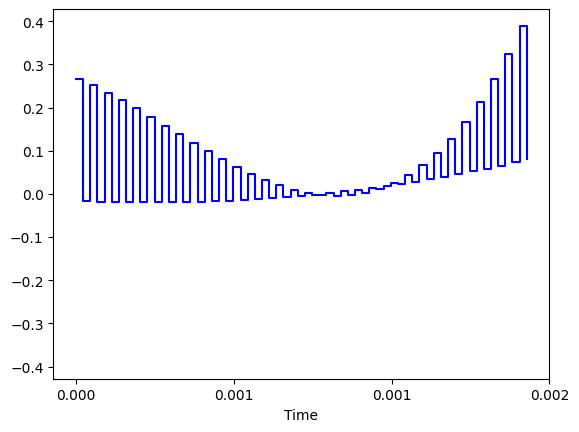

In [67]:
# plot the buffer (this takes a moment the first time)
plot(buffer)

PosixPath('/Users/josephine/Library/Caches/supriya/2025-03-14T00-02-46-563394.png')

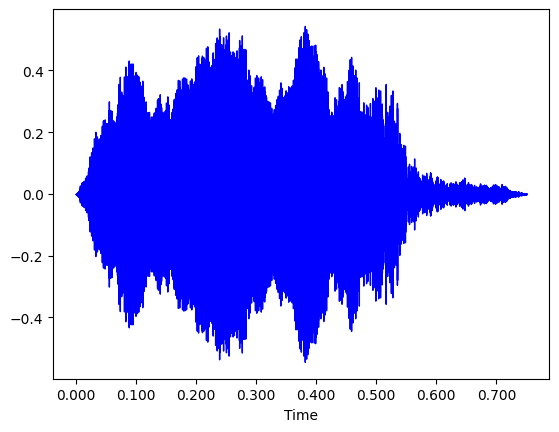

In [68]:
# read a file into a buffer
file_path = supriya.assets_path / "audio/birds/birds-01.wav"
other_buffer = server.add_buffer(file_path=file_path)
plot(other_buffer)

In [69]:
# import play helper
from supriya import play

In [70]:
# normally play() isn't async
# but for fussy reasons related to jupyter itself being async,
# we have to await here
await play(other_buffer)

(PosixPath('/Users/josephine/Library/Caches/supriya/audio-0c7c3ecda2db627616c356d1832925fd61bb4ab55870f54b5e3802f59a33608e.mp3'), 0)

In [71]:
# allocate a group of buffers, e.g.
buffer_group = server.add_buffer_group(count=4, frame_count=512, channel_count=1)
print(buffer_group)

BufferGroup(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=2, count=4)


In [72]:
# buffer groups don't actually have a concrete reality server-side
# but we can iterate over the buffers in the group
for buffer_ in buffer_group:
    print(buffer_)

Buffer(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=2, completion=None)
Buffer(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=3, completion=None)
Buffer(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=4, completion=None)
Buffer(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, id_=5, completion=None)


In [73]:
# free all the buffers
buffer.free()
other_buffer.free()
buffer_group.free()

## Non-realtime contexts: Scores

In [76]:
# import and instantiate a Score
from supriya import Score

(score := Score())

<Score [/Applications/SuperCollider.app/Contents/Resources/scsynth -N ...]>

In [77]:
# inspect the score's namespace
# note: no queries, only mutations
[name for name in dir(score) if not name.startswith("_")]

['add_buffer', 'add_buffer_group', 'add_bus', 'add_bus_group', 'add_group', 'add_synth', 'add_synthdefs', 'at', 'audio_input_bus_group', 'audio_output_bus_group', 'boot_status', 'clear_schedule', 'client_id', 'close_buffer', 'copy_buffer', 'default_group', 'do_nothing', 'fill_buffer', 'fill_bus_range', 'free_all_synthdefs', 'free_buffer', 'free_buffer_group', 'free_bus', 'free_bus_group', 'free_group_children', 'free_node', 'free_synthdefs', 'generate_buffer', 'iterate_datagrams', 'iterate_osc_bundles', 'iterate_request_bundles', 'latency', 'load_synthdefs', 'load_synthdefs_directory', 'map_node', 'move_node', 'name', 'normalize_buffer', 'options', 'order_nodes', 'pause_node', 'read_buffer', 'render', 'root_node', 'send', 'set_buffer', 'set_buffer_range', 'set_bus', 'set_bus_range', 'set_node', 'set_node_range', 'setup_system_synthdefs', 'unpause_node', 'write_buffer', 'zero_buffer']

In [78]:
# add a synthdef at timestamp 0
with score.at(0):
    score.add_synthdefs(supriya.default)

# strum a series of synths
synths = []
for i in range(12):
    with score.at(i / 4):
        frequency = 111 * (i + 1)
        synth = score.add_synth(synthdef=supriya.default, frequency=frequency)
        synths.append(synth)

# free all of them
with score.at(4):
    for synth in synths:
        synth.free()

# pad out a no-op while the envelopes decay
with score.at(5):
    score.do_nothing()

In [79]:
# play the score (and capture into the notebook)
from supriya import play

_ = await play(score)

In [80]:
# or just render the score to disk, returning the path and exit code
await score.render()

(PosixPath('/Users/josephine/Library/Caches/supriya/score-b005cf246a8be1496b14b3d793a63802a57c1ad573af5fb883710f71ee432c7d.aiff'), 0)

In [81]:
# this will error!
# no queries, only mutations
with score.at(0):
    score.query_tree()

AttributeError: 'Score' object has no attribute 'query_tree'

In [82]:
# iterate the osc bundles in the score
for bundle in score.iterate_osc_bundles():
    print(repr(bundle))

OscBundle(timestamp=0.0, contents=[OscMessage('/d_recv', b'SCgf\x00\x00\x00\x02\x00\x01\x07default\x00\x00\x00\x0c\x00\x00\x00\x00>\x99\x99\x9a<#\xd7\n?333@\x00\x00\x00\xbe\xcc\xcc\xcd>\xcc\xcc\xcdEz\x00\x00E\x9c@\x00E\x1c@\x00EH\x00\x00?\x80\x00\x00\x00\x00\x00\x05=\xcc\xcc\xcdC\xdc\x00\x00?\x80\x00\x00?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\tamplitude\x00\x00\x00\x00\tfrequency\x00\x00\x00\x01\x04gate\x00\x00\x00\x02\x03pan\x00\x00\x00\x03\x03out\x00\x00\x00\x04\x00\x00\x00\x14\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x01\x01\x01\x01\x06VarSaw\x02\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x01\x02\x05Linen\x01\x00\x00\x00\x05\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x03\xff\xff\xff\xff\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x04\x01\x07Control\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x04\x00\x04Rand\

In [83]:
# but actually we store an intermediate format... requests
for bundle in score.iterate_request_bundles():
    print(bundle)

RequestBundle(contents=[ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=None), NewSynth(synthdef=<SynthDef: default>, synth_id=1000, add_action=AddAction.ADD_TO_HEAD, target_node_id=0, controls={'frequency': 111.0})], timestamp=0.0)
RequestBundle(contents=[NewSynth(synthdef=<SynthDef: default>, synth_id=1001, add_action=AddAction.ADD_TO_HEAD, target_node_id=0, controls={'frequency': 222.0})], timestamp=0.25)
RequestBundle(contents=[NewSynth(synthdef=<SynthDef: default>, synth_id=1002, add_action=AddAction.ADD_TO_HEAD, target_node_id=0, controls={'frequency': 333.0})], timestamp=0.5)
RequestBundle(contents=[NewSynth(synthdef=<SynthDef: default>, synth_id=1003, add_action=AddAction.ADD_TO_HEAD, target_node_id=0, controls={'frequency': 444.0})], timestamp=0.75)
RequestBundle(contents=[NewSynth(synthdef=<SynthDef: default>, synth_id=1004, add_action=AddAction.ADD_TO_HEAD, target_node_id=0, controls={'frequency': 555.0})], timestamp=1.0)
RequestBundle(contents=[NewSynth(syn

## OSC

### OSC messages & bundles

In [84]:
from supriya import OscMessage, OscBundle

In [85]:
message = OscMessage("/this", "is", "a", "message?", 1, 2.5, False)

In [86]:
# print the interpretation representation
print(repr(message))

OscMessage('/this', 'is', 'a', 'message?', 1, 2.5, False)


In [87]:
# print the sclang-style hex representation
print(message)

size 44
   0   2f 74 68 69  73 00 00 00  2c 73 73 73  69 66 46 00   |/this...,sssifF.|
  16   69 73 00 00  61 00 00 00  6d 65 73 73  61 67 65 3f   |is..a...message?|
  32   00 00 00 00  00 00 00 01  40 20 00 00                |........@ ..|


In [88]:
bundle = OscBundle(timestamp=666.23, contents=[message, message])

In [89]:
# print the interpretation representation
print(repr(bundle))

OscBundle(timestamp=666.23, contents=[OscMessage('/this', 'is', 'a', 'message?', 1, 2.5, False), OscMessage('/this', 'is', 'a', 'message?', 1, 2.5, False)])


In [90]:
# print the sclang-style hex representation
print(bundle)

size 112
   0   23 62 75 6e  64 6c 65 00  83 aa 81 1a  3a e1 48 00   |#bundle.....:.H.|
  16   00 00 00 2c  2f 74 68 69  73 00 00 00  2c 73 73 73   |...,/this...,sss|
  32   69 66 46 00  69 73 00 00  61 00 00 00  6d 65 73 73   |ifF.is..a...mess|
  48   61 67 65 3f  00 00 00 00  00 00 00 01  40 20 00 00   |age?........@ ..|
  64   00 00 00 2c  2f 74 68 69  73 00 00 00  2c 73 73 73   |...,/this...,sss|
  80   69 66 46 00  69 73 00 00  61 00 00 00  6d 65 73 73   |ifF.is..a...mess|
  96   61 67 65 3f  00 00 00 00  00 00 00 01  40 20 00 00   |age?........@ ..|


### Sending messages

In [91]:
server.send(["/g_queryTree", 0])

### OSC Callbacks

In [97]:
captured_messages = []


def procedure(message):
    captured_messages.append(message)


print(
    callback := server.register_osc_callback(
        procedure=procedure, pattern=["/g_queryTree.reply"]
    )
)

OscCallback(pattern=('/g_queryTree.reply',), procedure=<function procedure at 0x13bf6efc0>, failure_pattern=None, once=False, args=None, kwargs=None)


In [98]:
server.send(["/g_queryTree", 0])

In [99]:
captured_messages

[OscMessage('/g_queryTree.reply', 0, 0, 1, 1, 1, 1001, 0)]

In [100]:
server.unregister_osc_callback(callback)

### Capturing IO

In [101]:
# OSC is actually handled by a "protocol" class
server.osc_protocol

In [102]:
with server.osc_protocol.capture() as transcript:
    with server.at() as moment:
        group = server.add_group()
        subgroup = group.add_group()
        with server.add_synthdefs(supriya.default) as completion:
            synth = subgroup.add_synth(synthdef=supriya.default, frequency=666)
    server.sync()

In [103]:
for entry in transcript:
    print(entry)

CaptureEntry(timestamp=1741925084.930078, label='S', message=OscBundle(contents=[OscMessage('/g_new', 1004, 0, 1, 1005, 0, 1004), OscMessage('/d_recv', b'SCgf\x00\x00\x00\x02\x00\x01\x07default\x00\x00\x00\x0c\x00\x00\x00\x00>\x99\x99\x9a<#\xd7\n?333@\x00\x00\x00\xbe\xcc\xcc\xcd>\xcc\xcc\xcdEz\x00\x00E\x9c@\x00E\x1c@\x00EH\x00\x00?\x80\x00\x00\x00\x00\x00\x05=\xcc\xcc\xcdC\xdc\x00\x00?\x80\x00\x00?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\tamplitude\x00\x00\x00\x00\tfrequency\x00\x00\x00\x01\x04gate\x00\x00\x00\x02\x03pan\x00\x00\x00\x03\x03out\x00\x00\x00\x04\x00\x00\x00\x14\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x01\x01\x01\x01\x06VarSaw\x02\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x01\x02\x05Linen\x01\x00\x00\x00\x05\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x03\xff\xff\xff\xff\x00\x00\x00\x01\xff\xff\

In [104]:
# the raw message is something else... an intermediate format
transcript[0].raw_message

RequestBundle(contents=[NewGroup(items=[(1004, AddAction.ADD_TO_HEAD, 1), (1005, AddAction.ADD_TO_HEAD, 1004)]), ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=NewSynth(synthdef=<SynthDef: default>, synth_id=1006, add_action=AddAction.ADD_TO_HEAD, target_node_id=1005, controls={'frequency': 666.0}))], timestamp=None)

In [105]:
moment

Moment(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, seconds=None, closed=True, requests=[(NewGroup(items=[(1004, AddAction.ADD_TO_HEAD, 1)]), None), (NewGroup(items=[(1005, AddAction.ADD_TO_HEAD, 1004)]), None), (ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=None), Completion(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, moment=..., requests=[(NewSynth(synthdef=<SynthDef: default>, synth_id=1006, add_action=AddAction.ADD_TO_HEAD, target_node_id=1005, controls={'frequency': 666.0}), None)]))])

In [106]:
completion

Completion(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, moment=Moment(context=<Server ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>, seconds=None, closed=True, requests=[(NewGroup(items=[(1004, AddAction.ADD_TO_HEAD, 1)]), None), (NewGroup(items=[(1005, AddAction.ADD_TO_HEAD, 1004)]), None), (ReceiveSynthDefs(synthdefs=(<SynthDef: default>,), on_completion=None), ...)]), requests=[(NewSynth(synthdef=<SynthDef: default>, synth_id=1006, add_action=AddAction.ADD_TO_HEAD, target_node_id=1005, controls={'frequency': 666.0}), None)])

In [107]:
server.quit()

<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

## Asyncio

from https://docs.python.org/3/library/asyncio.html:

> asyncio is a library to write concurrent code using the async/await syntax.

> asyncio is used as a foundation for multiple Python asynchronous frameworks that provide high-performance network and web-servers, database connection libraries, distributed task queues, etc.

> asyncio is often a perfect fit for IO-bound and high-level structured network code.

In [108]:
from supriya import AsyncServer

async_server = AsyncServer()

In [109]:
async def on_boot(event):
    with async_server.at():
        group = async_server.add_group()
        with async_server.add_synthdefs(supriya.default):
            synth = group.add_synth(synthdef=supriya.default, frequency=123)
    await async_server.sync()

In [110]:
async_server.register_lifecycle_callback("booted", on_boot)

ServerLifecycleCallback(events=(ServerLifecycleEvent.BOOTED,), procedure=<function on_boot at 0x13bf6e480>, once=False, args=None, kwargs=None)

In [111]:
# start to boot the server, using a random free port
from supriya import find_free_port

# the result of this is actually a coroutine: nothing has really run yet
(coro := async_server.boot(port=find_free_port()))

<coroutine object AsyncServer.boot at 0x113477790>

In [112]:
# once we await the coroutine, we're golden
await coro

<AsyncServer ONLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 51590]>

In [113]:
# async servers require async queries
print(await async_server.query_tree())

NODE TREE 0 group
    1 group
        1000 group
            1001 default
                amplitude: 0.1, frequency: 123.0, gate: 1.0, pan: 0.5, out: 0.0


In [114]:
# and now we can quit (asynchronously of course)
await async_server.quit()

<AsyncServer OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 51590]>

In [115]:
# there are async clocks too!
from supriya import AsyncClock, AsyncOfflineClock, OfflineClock

## Contexts

- Mutation interface (all contexts)
- Query interface (realtime only)
- Mutations are realtime/nonrealtime agnostic
- Mutations are concurrency agnostic (".send()" is _always_ sync)
- We can write code targeted against "Context" regardless of what kind

## Synthdefs

### Building SynthDefs (1)

In [ ]:
r"""
SynthDef(\simple, { arg out=0, freq=440;
    Out.ar(out, SinOsc.ar(freq));
});
"""

In [116]:
# A simple SynthDef using the builder pattern
from supriya.ugens import SynthDefBuilder
from supriya.ugens import Out, SinOsc

with SynthDefBuilder(freq=440, out=0) as builder:
    source = SinOsc.ar(frequency=builder["freq"])
    Out.ar(bus=builder["out"], source=source)

(simple_synthdef := builder.build(name="simple"))

<SynthDef: simple>

### Graphing SynthDefs

In [117]:
# a YAML-like textual representation
# this is useful for unit tests!
print(simple_synthdef)

synthdef:
    name: simple
    ugens:
    -   Control.kr:
            freq: 440.0
            out: 0.0
    -   SinOsc.ar:
            frequency: Control.kr[0:freq]
            phase: 0.0
    -   Out.ar:
            bus: Control.kr[1:out]
            source[0]: SinOsc.ar[0]


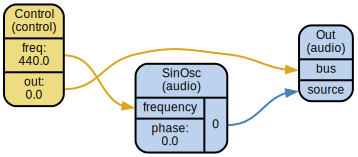

In [118]:
# a GraphViz representation
from supriya import graph

_ = graph(simple_synthdef)

### SynthDef internals

In [119]:
dir(simple_synthdef)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__graph__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_collect_indexed_parameters', '_compiled_graph', '_constants', '_controls', '_name', '_parameters', '_ugens', 'anonymous_name', 'compile', 'constants', 'controls', 'effective_name', 'has_gate', 'indexed_parameters', 'name', 'parameters', 'ugens']

In [120]:
simple_synthdef.name

'simple'

In [121]:
simple_synthdef.anonymous_name

'5759cf2cb562fc13c71f2d73c08e65b5'

In [122]:
simple_synthdef.effective_name

'simple'

In [123]:
simple_synthdef.parameters

mappingproxy({'freq': (<Parameter.kr(freq)>, 0), 'out': (<Parameter.kr(out)>, 1)})

In [124]:
simple_synthdef.ugens

(<Control.kr()>, <SinOsc.ar()>, <Out.ar()>)

In [125]:
simple_synthdef.has_gate

False

### Building SynthDefs (2)

In [ ]:
# this is the "default" synthdef as implemented in sclang
r"""
*makeDefaultSynthDef {
    SynthDef(\default, { arg out=0, freq=440, amp=0.1, pan=0, gate=1;
        var z;
        z = LPF.ar(
            Mix.new(VarSaw.ar(freq + [0, Rand(-0.4,0.0), Rand(0.0,0.4)], 0, 0.3, 0.3)),
            XLine.kr(Rand(4000,5000), Rand(2500,3200), 1)
        ) * Linen.kr(gate, 0.01, 0.7, 0.3, 2);
        OffsetOut.ar(out, Pan2.ar(z, pan, amp));
    }, [\ir]).add;
}
"""

In [126]:
# more imports
from supriya.enums import DoneAction, ParameterRate
from supriya.ugens import (
    LPF,
    Linen,
    Mix,
    OffsetOut,
    Pan2,
    Parameter,
    Rand,
    SynthDefBuilder,
    VarSaw,
    XLine,
)

In [127]:
# define a builder
builder = SynthDefBuilder(
    out=Parameter(rate=ParameterRate.SCALAR, value=0),
    amplitude=0.1,
    frequency=440,
    gate=1,
    pan=0.5,
)

In [128]:
# use the builder as a context manager
with builder:
    linen = Linen.kr(
        attack_time=0.01,
        done_action=DoneAction.FREE_SYNTH,
        gate=builder["gate"],
        release_time=0.3,
        sustain_level=0.7,
    )

In [129]:
# use the builder again
with builder:
    low_pass = LPF.ar(
        source=Mix.new(
            VarSaw.ar(
                frequency=builder["frequency"]
                + (
                    0,
                    Rand.ir(minimum=-0.4, maximum=0.0),
                    Rand.ir(minimum=0.0, maximum=0.4),
                ),
                width=0.3,
            )
        )
        * 0.3,
        frequency=XLine.kr(
            start=Rand.ir(minimum=4000, maximum=5000),
            stop=Rand.ir(minimum=2500, maximum=3200),
        ),
    )

In [130]:
# and again
with builder:
    panner = Pan2.ar(
        source=low_pass * linen * builder["amplitude"], position=builder["pan"]
    )

In [131]:
# and again and again
with builder:
    OffsetOut.ar(bus=builder["out"], source=panner)

In [132]:
(default := builder.build(name="default"))

<SynthDef: default>

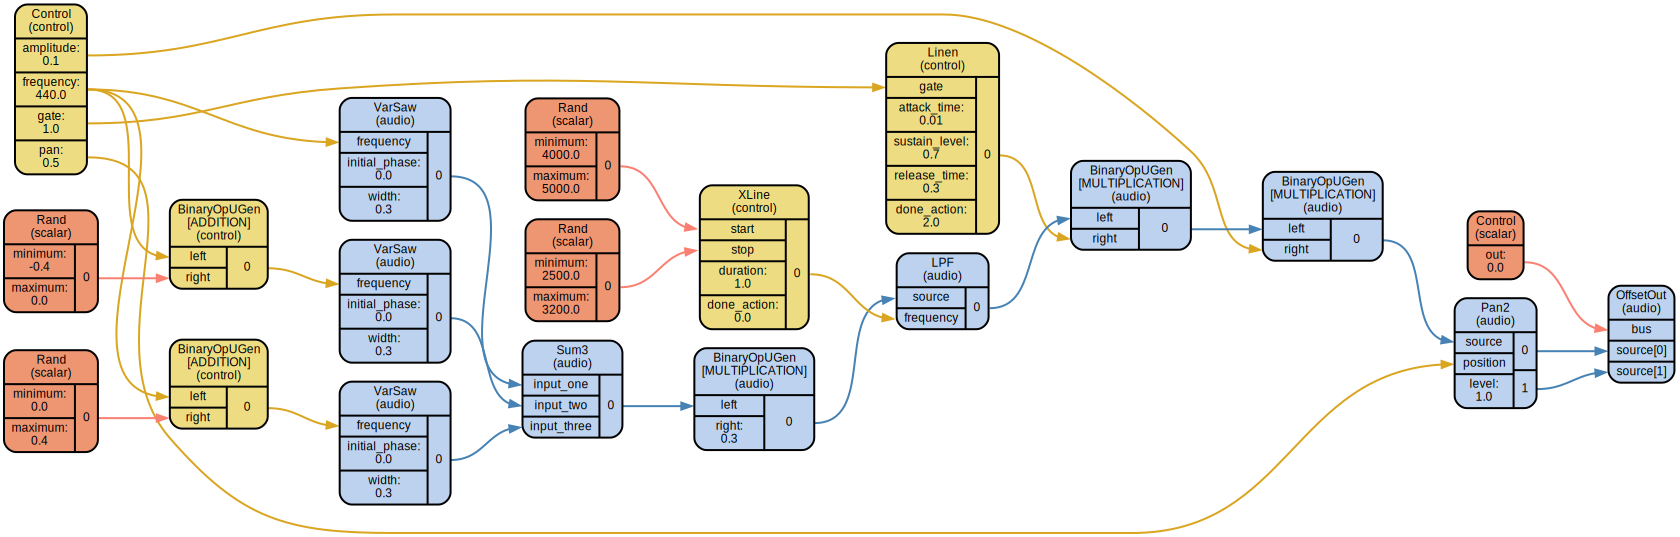

In [133]:
_ = graph(default)

### The `synthdef` decorator

In [134]:
# n.b. I'm not fond of this one because of
# a) how magical it is (not very, but just enough) but mainly because
# b) it makes type-checking difficult
# why difficult? the types of the keyword arguments aren't the same
# as the types of the values as they actually appear inside the function
# when executed at runtime. i can manage this with a mypy plugin,
# but that's just more work for me.
from supriya.ugens import synthdef

In [135]:
@synthdef("ir")
def default_decorated(out=0, amplitude=0.1, frequency=440, gate=1, pan=0.5):
    linen = Linen.kr(
        attack_time=0.01,
        done_action=DoneAction.FREE_SYNTH,
        gate=gate,
        release_time=0.3,
        sustain_level=0.7,
    )
    low_pass = LPF.ar(
        source=Mix.new(
            VarSaw.ar(
                frequency=frequency
                + (
                    0,
                    Rand.ir(minimum=-0.4, maximum=0.0),
                    Rand.ir(minimum=0.0, maximum=0.4),
                ),
                width=0.3,
            )
        )
        * 0.3,
        frequency=XLine.kr(
            start=Rand.ir(minimum=4000, maximum=5000),
            stop=Rand.ir(minimum=2500, maximum=3200),
        ),
    )
    panner = Pan2.ar(source=low_pass * linen * amplitude, position=pan)
    _ = OffsetOut.ar(bus=out, source=panner)

In [136]:
default_decorated

<SynthDef: default_decorated>

In [137]:
# why joséphine hates @synthdef()
from supriya.ugens import Out, SinOsc


@synthdef()
def foo(out=0):
    print(repr(out))  # not an integer!
    _ = Out.ar(source=SinOsc.kr())


foo

<Parameter.kr(out)>


<SynthDef: foo>

### UGen methods

In [138]:
dir(SinOsc)

['__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__ceil__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__floor__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__graph__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__invert__', '__iter__', '__le__', '__len__', '__lshift__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__pow__', '__radd__', '__rand__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rfloordiv__', '__rlshift__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__static_attributes__', '__str__', '__sub__', '__subclasshook__', '__synthdef__', '__truediv__', '__weakref__', '__xor__', '_

### SynthDef (de)compilation

In [139]:
# SynthDefs compile to byte strings
compiled = default.compile()
compiled

b'SCgf\x00\x00\x00\x02\x00\x01\x07default\x00\x00\x00\x0c<#\xd7\n?333>\x99\x99\x9a@\x00\x00\x00\x00\x00\x00\x00\xbe\xcc\xcc\xcd>\xcc\xcc\xcdEz\x00\x00E\x9c@\x00E\x1c@\x00EH\x00\x00?\x80\x00\x00\x00\x00\x00\x05=\xcc\xcc\xcdC\xdc\x00\x00?\x80\x00\x00?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\tamplitude\x00\x00\x00\x00\tfrequency\x00\x00\x00\x01\x04gate\x00\x00\x00\x02\x03pan\x00\x00\x00\x03\x03out\x00\x00\x00\x04\x00\x00\x00\x14\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x01\x01\x01\x01\x05Linen\x01\x00\x00\x00\x05\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x03\x01\x06VarSaw\x02\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xff\xff\xff\xff\x00\x00\x00\x04\xff\xff\xff\xff\x00\x00\x00\x02\x02\x07Control\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x04\x00\x04Rand\x00\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\xff\xff\xff\x

In [140]:
# valid byte strings can be decompiled back into SynthDefs
from supriya.ugens import decompile_synthdef

decompiled = decompile_synthdef(compiled)
decompiled

<SynthDef: default>

In [141]:
# sanity-check: the decompiled SynthDef is not the same in memory
default is decompiled

False

### Compiling via sclang

In [142]:
# Supriya provides utilities for compiling via sclang.
# This is intended for validating its own logic vs sclang (as a reference spec).
from supriya.ugens import SuperColliderSynthDef

sc_synthdef = SuperColliderSynthDef(
    "foo", "Out.ar(0, SinOsc.ar(freq: 420) * SinOsc.ar(freq: 440))"
)
sc_compiled_synthdef = sc_synthdef.compile()  # return bytes
sc_compiled_synthdef

compiling class library...
	Found 855 primitives.
	Compiling directory '/Applications/SuperCollider.app/Contents/Resources/SCClassLibrary'
	Compiling directory '/Users/josephine/Library/Application Support/SuperCollider/Extensions'
	numentries = 939044 / 14493240 = 0.065
	5706 method selectors, 2540 classes
	method table size 15170976 bytes, big table size 115945920
	Number of Symbols 13189
	Byte Code Size 406110
	compiled 409 files in 2.96 seconds
compile done
localhost : setting clientID to 0.
internal : setting clientID to 0.
Class tree inited in 0.01 seconds


*** Welcome to SuperCollider 3.13.0. *** For help type cmd-d.
Defined SynthDef
Wrote SynthDef
cleaning up OSC


b'SCgf\x00\x00\x00\x02\x00\x01\x03foo\x00\x00\x00\x03C\xd2\x00\x00\x00\x00\x00\x00C\xdc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x06SinOsc\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x01\x02\x06SinOsc\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\xff\xff\xff\xff\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x01\x02\x0cBinaryOpUGen\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x02\x03Out\x02\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00'

In [143]:
# The sclang-derived SynthDef byte string can be decompiled back into a SynthDef.
print(decompile_synthdef(sc_compiled_synthdef))

synthdef:
    name: foo
    ugens:
    -   SinOsc.ar/0:
            frequency: 420.0
            phase: 0.0
    -   SinOsc.ar/1:
            frequency: 440.0
            phase: 0.0
    -   BinaryOpUGen(MULTIPLICATION).ar:
            left: SinOsc.ar/0[0]
            right: SinOsc.ar/1[0]
    -   Out.ar:
            bus: 0.0
            source[0]: BinaryOpUGen(MULTIPLICATION).ar[0]


### UGen metaprogramming

In [144]:
from supriya.ugens import UGen, param, ugen


# A dupe of SinOsc
@ugen(ar=True, kr=True, is_pure=True)
class AnotherSinOsc(UGen):
    frequency = param(440.0)
    phase = param(0.0)

In [145]:
AnotherSinOsc.ar()

<AnotherSinOsc.ar()[0]>

In [146]:
AnotherSinOsc.kr()

<AnotherSinOsc.kr()[0]>

In [147]:
# This won't work because ir=True wasn't set
AnotherSinOsc.ir()

AttributeError: type object 'AnotherSinOsc' has no attribute 'ir'

In [148]:
# A dupe of Out
@ugen(ar=True, kr=True, is_output=True, channel_count=0, fixed_channel_count=True)
class AnotherOut(UGen):
    bus = param(0)
    source = param(unexpanded=True)


AnotherOut.ar(source=AnotherSinOsc.ar())

<AnotherOut.ar()>

In [149]:
from supriya.ugens.pv import PV_ChainUGen


# A dupe of PV_BinShift
@ugen(kr=True, is_width_first=True)
class AnotherPV_BinShift(PV_ChainUGen):
    pv_chain = param()
    stretch = param(1.0)
    shift = param(0.0)
    interpolate = param(0)


# This won't work because of missing pv_chain argument
AnotherPV_BinShift.kr()

TypeError: AnotherPV_BinShift.kr() missing 1 required keyword-only argument: 'pv_chain'

In [150]:
help(ugen)

Help on function ugen in module supriya.ugens.core:

ugen(
    *,
    ar: bool = False,
    kr: bool = False,
    ir: bool = False,
    dr: bool = False,
    new: bool = False,
    has_done_flag: bool = False,
    is_input: bool = False,
    is_multichannel: bool = False,
    is_output: bool = False,
    is_pure: bool = False,
    is_width_first: bool = False,
    channel_count: int = 1,
    fixed_channel_count: bool = False,
    signal_range: Optional[int] = None
) -> Callable[[Type[ForwardRef('UGen')]], Type[ForwardRef('UGen')]]
    Decorate a UGen class.

    Akin to dataclasses.dataclass.

    Collects parameter descriptors and generates initializer and rate class methods.



## Clocks

In [151]:
# import Clock and instantiate one
from supriya import Clock

(clock := Clock())

In [152]:
# clocks have bpm tempo
clock.beats_per_minute

120.0

In [153]:
# clocks have time signatures!
clock.time_signature

(4, 4)

In [154]:
# define a simple callback
# this will print the "clock context"
# and return a delta of 1/4 (a quarter note)
# and on the 5th invocation will return a null delta, preventing re-scheduling
def clock_callback(context):
    print(context)
    if context.event.invocations == 4:
        return None
    return 0.25

In [155]:
# schedule the callback to be run immediately
clock.schedule(clock_callback)

0

In [156]:
# start the clock
clock.start()

ClockContext(current_moment=Moment(beats_per_minute=120.0, measure=1, measure_offset=0.0001430511474609375, offset=0.0001430511474609375, seconds=1741925210.73792, time_signature=(4, 4)), desired_moment=Moment(beats_per_minute=120.0, measure=1, measure_offset=0.0, offset=0.0, seconds=1741925210.737634, time_signature=(4, 4)), event=CallbackEvent(event_id=0, event_type=<EventType.SCHEDULE: 1>, seconds=1741925210.737634, measure=None, offset=0.0, procedure=<function clock_callback at 0x13c195ee0>, args=None, kwargs=None, invocations=0))
ClockContext(current_moment=Moment(beats_per_minute=120.0, measure=1, measure_offset=0.25016748905181885, offset=0.25016748905181885, seconds=1741925211.237969, time_signature=(4, 4)), desired_moment=Moment(beats_per_minute=120.0, measure=1, measure_offset=0.25, offset=0.25, seconds=1741925211.237634, time_signature=(4, 4)), event=CallbackEvent(event_id=0, event_type=<EventType.SCHEDULE: 1>, seconds=1741925211.237634, measure=None, offset=0.25, procedure=

In [157]:
# stop the clock
clock.stop()

## Patterns

### Sequence patterns

In [158]:
# let's make a "sequence pattern", akin to Pseq
from supriya.patterns import SequencePattern

sequence_pattern = SequencePattern([111, 150, 180], iterations=2)
sequence_pattern, sequence_pattern.is_infinite

(<supriya.patterns.patterns.SequencePattern object at 0x13bf438c0>, False)

In [159]:
# patterns are iterable, so we can loop over them
for x in sequence_pattern:
    print(x)

111
150
180
111
150
180


### Random patterns

In [160]:
# let's make a "random pattern", akin to Pwhite
from supriya.patterns import RandomPattern

random_pattern = RandomPattern(-1.0, 1.0)
random_pattern, random_pattern.is_infinite  # the pattern is infinite by default

(<supriya.patterns.noise.RandomPattern object at 0x13bf41160>, True)

In [161]:
# because this pattern is infinite we need to break at some point
# we'll use the built-in enumerate() to yield an index we can break on
for i, x in enumerate(random_pattern):
    print(i, x)
    if i == 3:
        break

0 0.0318588472841741
1 0.2123197609421852
2 -0.8142531439087091
3 -0.028405122582680464


### Pattern math

In [162]:
# let's make some choice patterns, akin to Prand
from supriya.patterns import ChoicePattern

frequency_pattern = ChoicePattern(
    [440, 555, 666, [333.33, 366.66], 345], iterations=None
) * ChoicePattern([1, 0.5, 2, 0.25, 4], iterations=None)
for i, x in enumerate(frequency_pattern):
    print(i, x)
    if i == 3:
        break

0 172.5
1 (1333.32, 1466.64)
2 277.5
3 690


### Event patterns

In [163]:
# now create an event pattern, akin to Pbind
from supriya.patterns import EventPattern

event_pattern = EventPattern(
    delta=RandomPattern(0.5, 2),
    duration=RandomPattern(0.05, 0.2),
    frequency=frequency_pattern,
    pan=RandomPattern(-1.0, 1.0),
    synthdef=supriya.default,
)
event_pattern, event_pattern.is_infinite

(<supriya.patterns.eventpatterns.EventPattern object at 0x13bf42900>, True)

In [164]:
# event patterns yield events
for i, event in enumerate(event_pattern):
    print(event)
    if i == 3:
        break

NoteEvent(UUID('b8fec387-c325-47ae-972a-42553ac90579'), delta=1.7191318287510988, duration=0.11627554320221302, frequency=555, pan=0.31511535971050675, synthdef=<SynthDef: default>)
NoteEvent(UUID('f68ef69a-922e-4fa3-9ee7-bce0ce87eb78'), delta=0.640015197903031, duration=0.15674776296157722, frequency=(83.3325, 91.665), pan=-0.009650152041460691, synthdef=<SynthDef: default>)
NoteEvent(UUID('12ac4567-2e65-499d-873f-e8a014c14c4e'), delta=0.9187326783747536, duration=0.0541381323339272, frequency=277.5, pan=-0.47434606609460395, synthdef=<SynthDef: default>)
NoteEvent(UUID('88f97044-6788-451c-b3db-1bb0c259a3ae'), delta=1.5652553571124563, duration=0.10772092848461223, frequency=555, pan=0.254178881056889, synthdef=<SynthDef: default>)


### Structural patterns: buses

In [165]:
# we can build more complex event patterns
# BusPattern (akin to Pbus) will create a private bus, a group, and link synths
from supriya.patterns import BusPattern

bus_isolated_event_pattern = BusPattern(event_pattern, channel_count=2)

In [166]:
for i, event in enumerate(bus_isolated_event_pattern):
    print(event)
    if i == 3:
        break

CompositeEvent([
    BusAllocateEvent(UUID('2160632f-bb1b-4ee5-b2f6-d75229dd7467'), calculation_rate=CalculationRate.AUDIO, channel_count=2),
    GroupAllocateEvent(UUID('88eae95f-ce00-49aa-8eb5-07a2c8b4f89e')),
    SynthAllocateEvent(UUID('07757fc2-f7da-4627-a16e-55499251cfd2'), <SynthDef: system_link_audio_2>, add_action=AddAction.ADD_AFTER, amplitude=1.0, fade_time=0.25, in_=UUID('2160632f-bb1b-4ee5-b2f6-d75229dd7467'), target_node=UUID('88eae95f-ce00-49aa-8eb5-07a2c8b4f89e')),
])
NoteEvent(UUID('e2054dba-a183-4be5-8f1b-9780652e824f'), delta=1.589516136578568, duration=0.1067408163403481, frequency=333.0, out=UUID('2160632f-bb1b-4ee5-b2f6-d75229dd7467'), pan=-0.6114193377582431, synthdef=<SynthDef: default>, target_node=UUID('88eae95f-ce00-49aa-8eb5-07a2c8b4f89e'))
NoteEvent(UUID('9438e0fb-f575-4179-b157-8e2b2eca9aaf'), delta=1.7549245592869807, duration=0.13922763839307278, frequency=166.5, out=UUID('2160632f-bb1b-4ee5-b2f6-d75229dd7467'), pan=0.563446165438046, synthdef=<SynthDef:

### Aside: some effects SynthDefs

In [167]:
# now let's define a couple synthdefs for fx
from supriya.ugens import (
    AllpassC,
    FreeVerb,
    HPF,
    In,
    LFNoise1,
    Linen,
    LocalIn,
    LocalOut,
    ReplaceOut,
)

In [168]:
@synthdef()
def delay(out=0, gate=1):
    envelope = Linen.kr(gate=gate, release_time=0.25, done_action=2)
    source = In.ar(bus=out, channel_count=2)
    tap = AllpassC.ar(
        source=LocalIn.ar(channel_count=2),
        maximum_delay_time=1.0,
        delay_time=LFNoise1.kr(frequency=0.05).scale(-1, 1, 0, 1),
    )
    LocalOut.ar(source=HPF.ar(source=source + tap, frequency=1000) * -0.995)
    Out.ar(bus=out, source=tap * envelope)

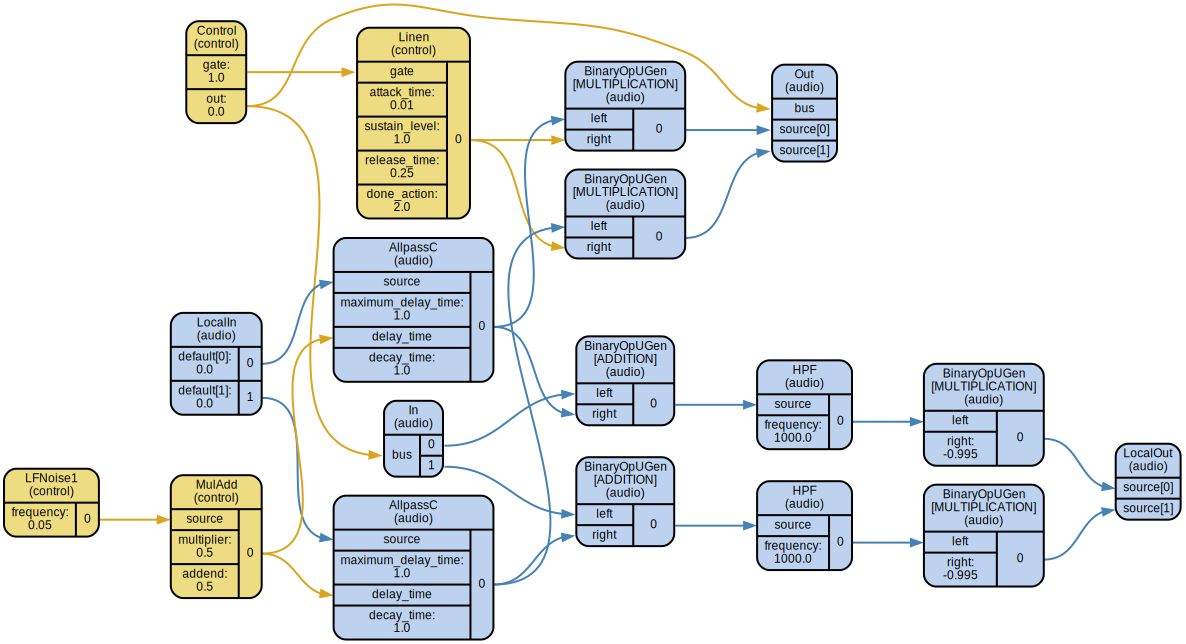

In [169]:
_ = graph(delay)

In [170]:
@synthdef()
def reverb(out=0, gate=1):
    envelope = Linen.kr(gate=gate, release_time=0.25, done_action=2)
    source = In.ar(bus=out, channel_count=2)
    source = FreeVerb.ar(source=source, mix=0.5, damping=0.5, room_size=0.95)
    ReplaceOut.ar(bus=out, source=source * envelope)

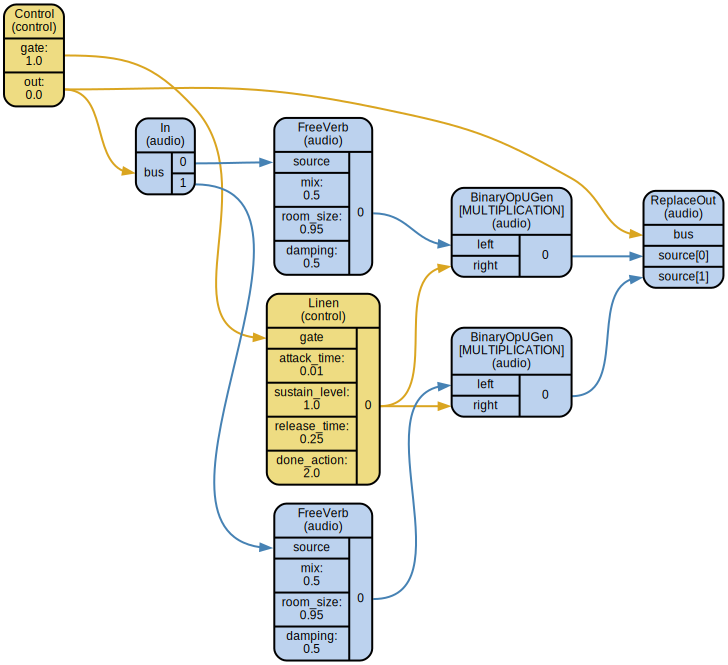

In [171]:
_ = graph(reverb)

### Structural patterns: effects

In [172]:
# now some Pfx-type stuff
from supriya.patterns import FxPattern

bus_isolated_fx_pattern = BusPattern(
    FxPattern(event_pattern, synthdef=delay),
    channel_count=2,
)

In [173]:
# note the second CompositeEvent, coming from the FxPattern
for i, event in enumerate(bus_isolated_fx_pattern):
    print(event)
    if i == 3:
        break

CompositeEvent([
    BusAllocateEvent(UUID('bb8457d6-d5e7-475f-af63-92bf06c2bbf5'), calculation_rate=CalculationRate.AUDIO, channel_count=2),
    GroupAllocateEvent(UUID('a4aa93b7-5547-47ca-8376-281e3d87683a')),
    SynthAllocateEvent(UUID('ca323583-98b4-4c3e-b6c3-8c59776ada36'), <SynthDef: system_link_audio_2>, add_action=AddAction.ADD_AFTER, amplitude=1.0, fade_time=0.25, in_=UUID('bb8457d6-d5e7-475f-af63-92bf06c2bbf5'), target_node=UUID('a4aa93b7-5547-47ca-8376-281e3d87683a')),
])
CompositeEvent([
    SynthAllocateEvent(UUID('52c6d05b-ec7b-4f3a-8db5-4af1978296ce'), <SynthDef: delay>, add_action=AddAction.ADD_TO_TAIL, out=UUID('bb8457d6-d5e7-475f-af63-92bf06c2bbf5'), target_node=UUID('a4aa93b7-5547-47ca-8376-281e3d87683a')),
])
NoteEvent(UUID('e2a247fa-f3e0-465c-b8a2-823ea6e8e598'), delta=1.452647396250692, duration=0.11102574421702772, frequency=172.5, out=UUID('bb8457d6-d5e7-475f-af63-92bf06c2bbf5'), pan=-0.6296593377845543, synthdef=<SynthDef: default>, target_node=UUID('a4aa93b7-

### Structural patterns: parallelism

In [174]:
# now let's do it in parallel, Ppar-style
from supriya.patterns import GroupPattern, ParallelPattern

final_pattern = BusPattern(
    FxPattern(
        pattern=GroupPattern(ParallelPattern([bus_isolated_fx_pattern] * 4)),
        synthdef=reverb,
    ),
    channel_count=2,
)

In [175]:
for i, event in enumerate(final_pattern):
    print(event)
    if i == 3:
        break

CompositeEvent([
    BusAllocateEvent(UUID('6a8ce73c-7ea2-4e1a-8988-d5a2aeec7fdf'), calculation_rate=CalculationRate.AUDIO, channel_count=2),
    GroupAllocateEvent(UUID('a6e589b8-6511-4f48-ab50-029270d98078')),
    SynthAllocateEvent(UUID('f953c5d4-f93b-40ba-a751-0198b487039d'), <SynthDef: system_link_audio_2>, add_action=AddAction.ADD_AFTER, amplitude=1.0, fade_time=0.25, in_=UUID('6a8ce73c-7ea2-4e1a-8988-d5a2aeec7fdf'), target_node=UUID('a6e589b8-6511-4f48-ab50-029270d98078')),
])
CompositeEvent([
    SynthAllocateEvent(UUID('a5d7d4ec-ad55-4e2a-9c39-416adfa0bd46'), <SynthDef: reverb>, add_action=AddAction.ADD_TO_TAIL, out=UUID('6a8ce73c-7ea2-4e1a-8988-d5a2aeec7fdf'), target_node=UUID('a6e589b8-6511-4f48-ab50-029270d98078')),
])
CompositeEvent([
    GroupAllocateEvent(UUID('a7e2b0eb-def9-451a-8a84-d631f06031d1'), target_node=UUID('a6e589b8-6511-4f48-ab50-029270d98078')),
])
CompositeEvent([
    CompositeEvent([
        BusAllocateEvent(UUID('88127afd-185d-4a08-b7c9-0d3ef21bb2e4'), ca

### Pattern players

In [176]:
# ok, let's play it
def on_boot(event):
    server.add_synthdefs(supriya.default, delay, reverb)
    server.sync()


server = Server()
server.register_lifecycle_callback("booted", on_boot)
server.boot()
clock = Clock()

In [177]:
(pattern_player := final_pattern.play(context=server, clock=clock))

In [178]:
print(server.query_tree())

NODE TREE 0 group
    1 group
        1000 group
            1003 group
                1017 group
                    1021 default
                        amplitude: 0.1, frequency: 440.0, gate: 0.0, pan: -0.401104, out: 24.0
                    1019 delay
                        gate: 1.0, out: 24.0
                1018 system_link_audio_2
                    done_action: 2.0, fade_time: 0.25, gate: 1.0, in_: 24.0, out: 16.0
                1013 group
                    1015 delay
                        gate: 1.0, out: 22.0
                1014 system_link_audio_2
                    done_action: 2.0, fade_time: 0.25, gate: 1.0, in_: 22.0, out: 16.0
                1009 group
                    1011 delay
                        gate: 1.0, out: 20.0
                1010 system_link_audio_2
                    done_action: 2.0, fade_time: 0.25, gate: 1.0, in_: 20.0, out: 16.0
                1004 group
                    1006 delay
                        gate: 1.0, out: 18.0
    

In [179]:
pattern_player.stop()

In [180]:
server.quit()

<Server OFFLINE [/Applications/SuperCollider.app/Contents/Resources/scsynth -R 0 -l 1 -u 57110]>

## Cleanliness

- ci/cd
- docs
- testing
- typing

## Future work?

- More docs
- More examples
- DAW affordances
    - multi-context mixers
    - tracks & subtracks
    - send & receives
    - modulation
    - transport

## Ciao ciao!

Questions?

Thanks, darlings! <br/>
xoxo, joséphine

https://josephine-wolf-oberholtzer.com/ <br/>
https://github.com/supriya-project/supriya/

<div style="display: flex; flex-direction: row; justify-content: space-around;">
  <div style="text-align: center;">
    <img src="qr-bio.png" height="250" width="250"/><br />
    BIO
  </div>
  <div><img src="apsara.jpg" width="250"/></div>
  <div style="text-align: center;">
    <img src="qr-github.png" height="250" width="250"/><br />
    GITHUB
  </div>
</div>